# Kaggle - Categorical Feature Encoding Challenge II

### Binary classification, with every feature a categorical (and interactions!)

[https://www.kaggle.com/c/cat-in-the-dat-ii](https://www.kaggle.com/c/cat-in-the-dat-ii)

## 1st Place Solution

Congrats to all the participants in this great and challenging tabular competition! Thank you  Kaggle for organizing this competition.

My solution is very simple, NN plays a key role. The categorical features, especially with high cardinality are very suitable for neural network to exert its power.

### About models: 
4x NN,  1x Catboost, and blend of some of public kernels.  All NN models on same features,  and one of them resulted in 0.78672 on the public LB. Thanks to @sergey and @siavash for sharing the public kernels, I used them in blending.

### Feature engineering for NN models:

1. All features are converted into category type then Label Encoding
2. Ordinal Encoding: (ord_1 ~ ord_5) -> (ord_1_en ~ ord_5_en)

That’s all.

### NN Models
In our solution, we used several state-of-the-art models for CTR prediction, including CIN in xDeepFM, PNN, Cross in DCN, AutoInt, etc.

1. Linear+DNN+CIN (0.78672 public LB)
2. FM+Cross+PNN (0.78655 public LB)
3. FM+DCN+DNN (0.78652 public LB)
4. Linear+DNN+AutoInt (0.78665 public LB)

There are many components available for feature extraction on tabular data and they can be combined with various ways. It is a huge workload to trail by coding from scratch every time. **Deeptables** greatly simplifies this job with only a few lines of code. 

[https://github.com/DataCanvasIO/deeptables](https://github.com/DataCanvasIO/deeptables).

In [1]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from tensorflow.keras.utils import plot_model

import pandas as pd
import numpy as np
import tensorflow as tf

### Loading data

Please download datasets from https://www.kaggle.com/c/cat-in-the-dat-ii/data to the local directory `cat-in-the-dat-ii` by yourself.

In [2]:
%%time

data_path = 'cat-in-the-dat-ii'
train = pd.read_csv(f'{data_path}/train.csv')
test = pd.read_csv(f'{data_path}/test.csv')
submission = pd.read_csv(f'{data_path}/sample_submission.csv')

CPU times: user 10.4 s, sys: 1.2 s, total: 11.6 s
Wall time: 3.69 s


### Ordinal Encoding: ord_1 ~ ord_5 -> ord_1_en ~ ord_5_en

In [3]:
%%time

ord_order = [
    [1.0, 2.0, 3.0],
    ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster'],
    ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
]

for i in range(1, 3):
    ord_order_dict = {i : j for j, i in enumerate(ord_order[i])}
    train[f'ord_{i}_en'] = train[f'ord_{i}'].fillna('NULL').map(ord_order_dict)
    test[f'ord_{i}_en'] = test[f'ord_{i}'].fillna('NULL').map(ord_order_dict)
    
for i in range(3, 6):
    ord_order_dict = {i : j for j, i in enumerate(sorted(list(set(list(train[f'ord_{i}'].dropna().unique()) + list(test[f'ord_{i}'].dropna().unique())))))}
    train[f'ord_{i}_en'] = train[f'ord_{i}'].fillna('NULL').map(ord_order_dict)
    test[f'ord_{i}_en'] = test[f'ord_{i}'].fillna('NULL').map(ord_order_dict)

CPU times: user 24.5 s, sys: 2.53 s, total: 27.1 s
Wall time: 1.55 s


### Convert into `categroy`.

In [4]:
%%time

cat_cols = [c for c in train.columns if '_en' not in c and c != 'target']
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [5]:
%%time

y = train['target']
X = train
X.drop(['target','id'], axis=1, inplace=True)

X_test = test
X_test.drop(['id'], axis=1, inplace=True)
print(f'X shape: {X.shape}, y shape: {y.shape}, X_test shape: {X_test.shape}')

X shape: (600000, 28), y shape: (600000,), X_test shape: (400000, 28)


## Training Settings

In [ ]:
n_folds=3 #for faster demo, in the competition is 50
epochs=1 #for faster demo, in the competition is 100
batch_size=128

## Linear+DNN+CIN - a varient of xDeepFM

In [6]:
%%time

conf = ModelConfig(
    dnn_params={
        'hidden_units':((300, 0.3, True),(300, 0.3, True),), #hidden_units
        'dnn_activation':'relu',
    },
    fixed_embedding_dim=True,
    embeddings_output_dim=20,
    nets =['linear','cin_nets','dnn_nets'],
    stacking_op = 'add',
    output_use_bias = False,
    cin_params={
       'cross_layer_size': (200, 200),
       'activation': 'relu',
       'use_residual': False,
       'use_bias': True,
       'direct': True, 
       'reduce_D': False,
    },
)

dt = DeepTable(config = conf)
oof_proba, eval_proba, test_prob = dt.fit_cross_validation(
    X, y, X_eval=None, X_test=X_test, 
    num_folds=n_folds, stratified=False, iterators=None, 
    batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[], n_jobs=1)

Start cross validation
2 class detected, {0, 1}, so inferred as a [binary classification] task
Preparing features cost:0.19865846633911133
Imputation cost:6.917970657348633
Categorical encoding cost:16.448770761489868
fit_transform cost:23.712860822677612
transform X_test
transform_X cost:176.98967289924622
Iterators:KFold(n_splits=3, random_state=9527, shuffle=True)
Injected a callback [EarlyStopping]. monitor:val_AUC, patience:1, mode:max


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Fold:1

1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (23)', 'input_continuous_all: (5)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [4, 4, 4, 4, 4, 5, 8, 8, 8, 6, 1222, 1521, 224, 224, 2220, 5, 7, 8, 17, 28, 192, 9, 14]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 465)
---------------------------------------------------------
nets: ['linear', 'dnn_nets', 'cin_nets']
---------------------------------------------------------
linear: inpu

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.4min finished


fit_cross_validation cost:523.647552728653
CPU times: user 17min 46s, sys: 2min 21s, total: 20min 8s
Wall time: 8min 43s


### Output submission

In [7]:
submission['target'] = test_prob
submission.to_csv(f'submission_linear_dnn_cin_kfold50.csv',index=False)

### Plot model

Load model from disk:dt_output/dt_20200324 154910_linear_dnn_nets_cin_nets/linear_dnn_nets_cin_nets-kfold-3.h5.
1 Physical GPUs, 1 Logical GPUs


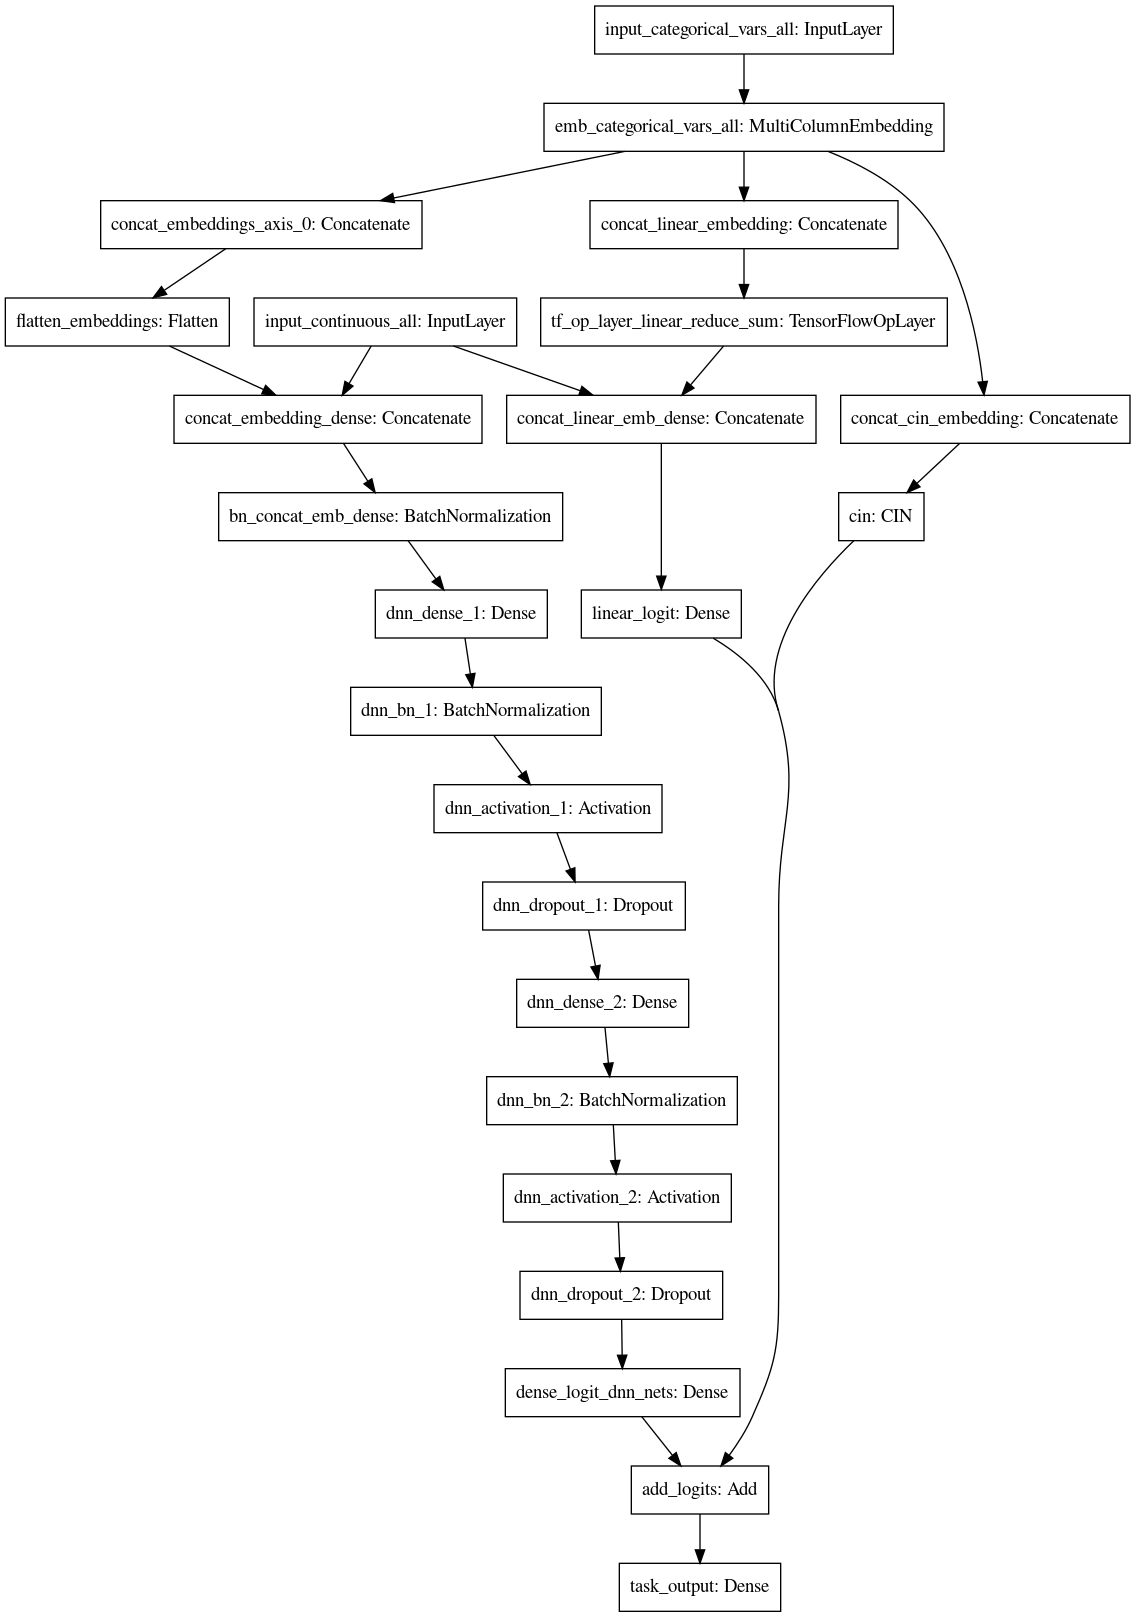

In [8]:
plot_model(dt.get_model().model,rankdir='TB')

## Linear+DNN+AutoInt

In [9]:
%%time

conf = ModelConfig(
    dnn_params={
        'hidden_units':((300, 0.3, True),(300, 0.3, True),), #hidden_units
        'dnn_activation':'relu',
    },
    fixed_embedding_dim=True,
    embeddings_output_dim=20,
    nets =['linear','autoint_nets','dnn_nets'],
    output_use_bias = False,
    autoint_params={
        'num_attention': 3,
        'num_heads': 1,
        'dropout_rate': 0,
        'use_residual': True,
    },
)

dt = DeepTable(config = conf)
oof_proba, eval_proba, test_prob = dt.fit_cross_validation(
    X, y, X_eval=None, X_test=X_test, 
    num_folds=n_folds, stratified=False, iterators=None,
    batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[], n_jobs=1)

Start cross validation
2 class detected, {0, 1}, so inferred as a [binary classification] task
Preparing features cost:0.20935845375061035
Imputation cost:6.592493295669556
Categorical encoding cost:16.10503888130188
fit_transform cost:23.096850633621216
transform X_test
transform_X cost:183.24825382232666
Iterators:KFold(n_splits=3, random_state=9527, shuffle=True)
Injected a callback [EarlyStopping]. monitor:val_AUC, patience:1, mode:max


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Fold:1

1 Physical GPUs, 1 Logical GPUs
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (23)', 'input_continuous_all: (5)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [4, 4, 4, 4, 4, 5, 8, 8, 8, 6, 1222, 1521, 224, 224, 2220, 5, 7, 8, 17, 28, 192, 9, 14]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 465)
---------------------------------------------------------
nets: ['linear', 'dnn_nets', 'autoint_nets']
---------------------------------------------------------
linear: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min finished


fit_cross_validation cost:507.61229848861694
CPU times: user 17min 54s, sys: 2min 15s, total: 20min 9s
Wall time: 8min 27s


### Output submission

In [10]:
submission['target'] = test_prob
submission.to_csv(f'submission_linear_dnn_autoint_kfold50.csv',index=False)

### Plot model

Load model from disk:dt_output/dt_20200324 155806_linear_dnn_nets_autoint_nets/linear_dnn_nets_autoint_nets-kfold-3.h5.
1 Physical GPUs, 1 Logical GPUs


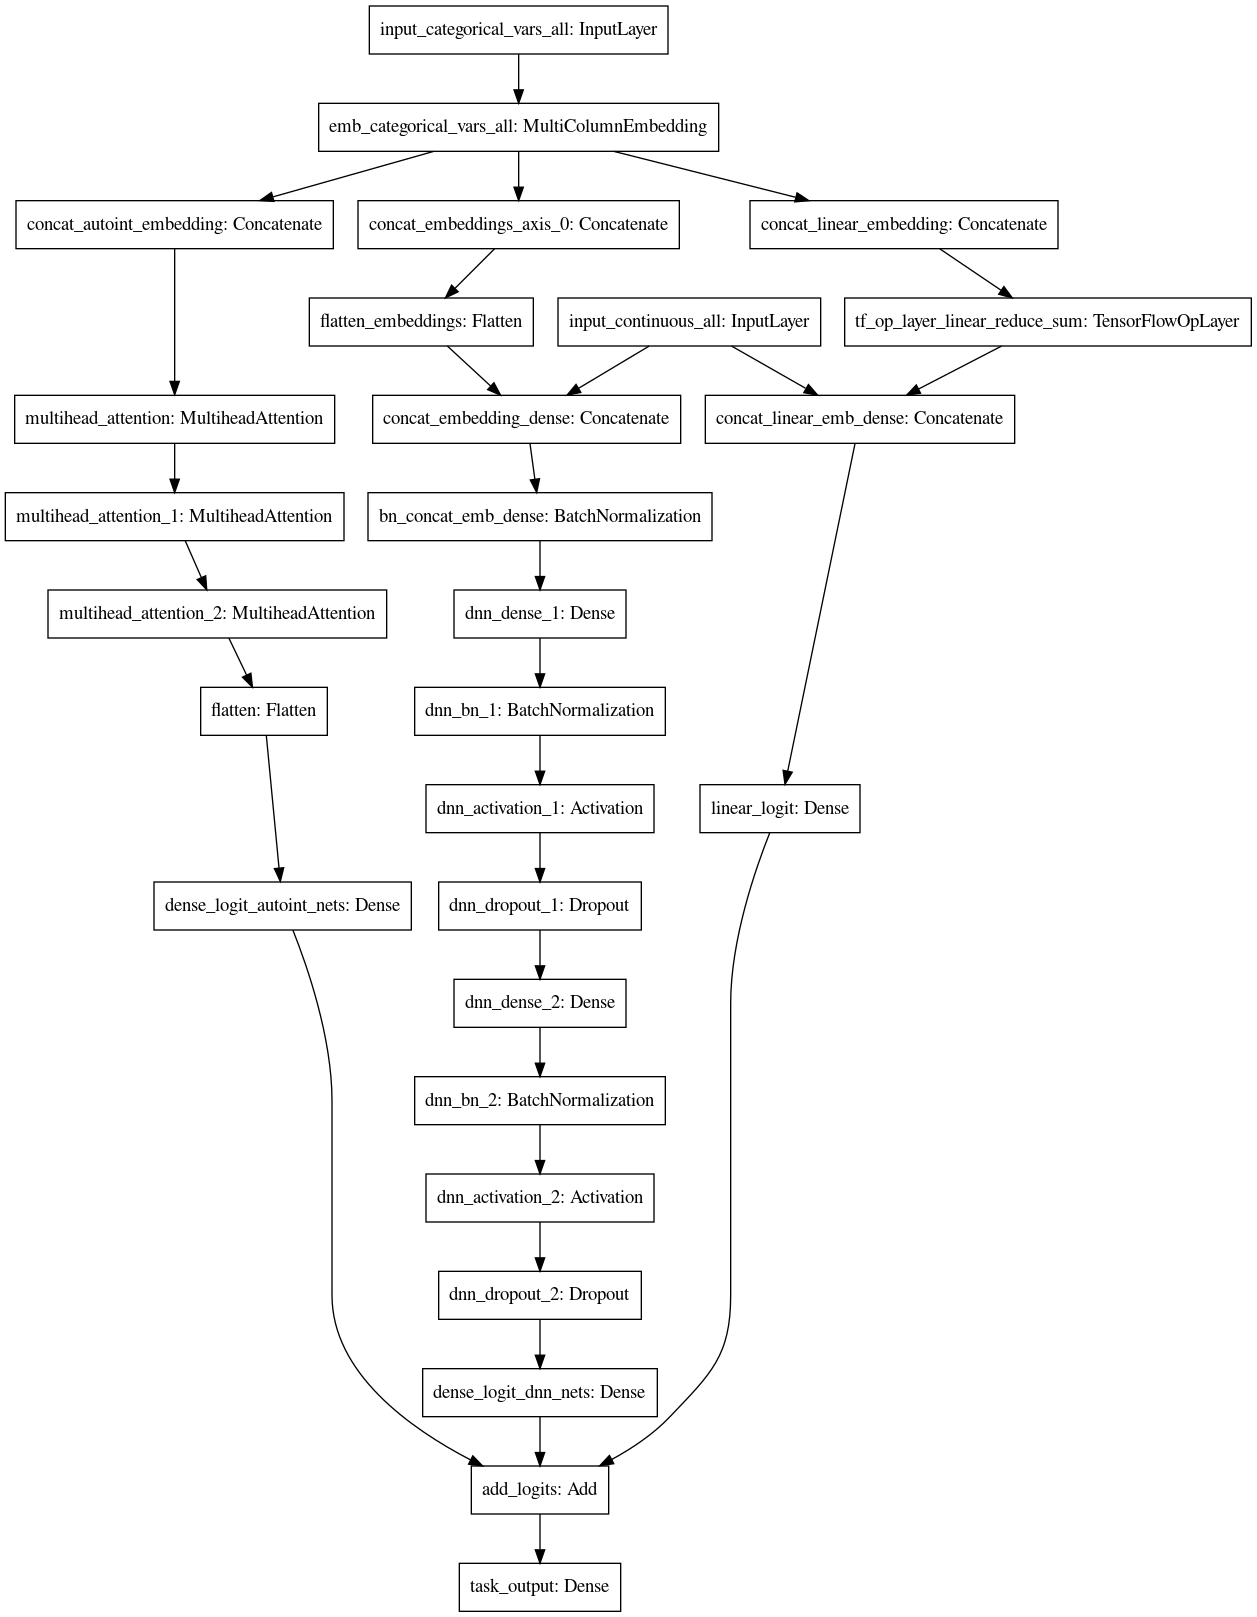

In [11]:
plot_model(dt.get_model().model,rankdir='TB')

## FM+DCN+DNN

In [12]:
%%time

conf = ModelConfig(
    dnn_params={
        'hidden_units':((300, 0.3, True),(300, 0.3, True),), #hidden_units
        'dnn_activation':'relu',
    },
    fixed_embedding_dim=True, 
    embeddings_output_dim=20, 
    nets =['fm_nets','dcn_nets','dnn_nets'],
    output_use_bias = False,
    cross_params={
        'num_cross_layer': 4,
    },
)

dt = DeepTable(config = conf)
oof_proba, eval_proba, test_prob  = dt.fit_cross_validation(
    X, y, X_eval=None, X_test=None, 
    num_folds=n_folds, stratified=False, iterators=None,
    batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[], n_jobs=1)

Start cross validation
2 class detected, {0, 1}, so inferred as a [binary classification] task
Preparing features cost:0.01894521713256836
Imputation cost:0.04121232032775879
Categorical encoding cost:0.05318951606750488
fit_transform cost:0.1182854175567627
Iterators:KFold(n_splits=3, random_state=9527, shuffle=True)
Injected a callback [EarlyStopping]. monitor:val_AUC, patience:1, mode:max

Fold:1

1 Physical GPUs, 1 Logical GPUs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (23)', 'input_continuous_all: (5)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [4, 4, 4, 4, 4, 5, 8, 8, 8, 6, 592, 669, 206, 194, 748, 5, 7, 8, 17, 28, 174, 9, 14]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 465)
---------------------------------------------------------
nets: ['dcn_nets', 'dnn_nets', 'fm_nets']
---------------------------------------------------------
dcn-widecross: input_shape (None, 465), output_shape (N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.3s finished


### Output submission

In [13]:
submission['target'] = test_prob
submission.to_csv(f'submission_fm_dcn_dnn_kfold50.csv',index=False)

### Plot model

Load model from disk:dt_output/dt_20200324 160650_dcn_nets_dnn_nets_fm_nets/dcn_nets_dnn_nets_fm_nets-kfold-3.h5.
1 Physical GPUs, 1 Logical GPUs


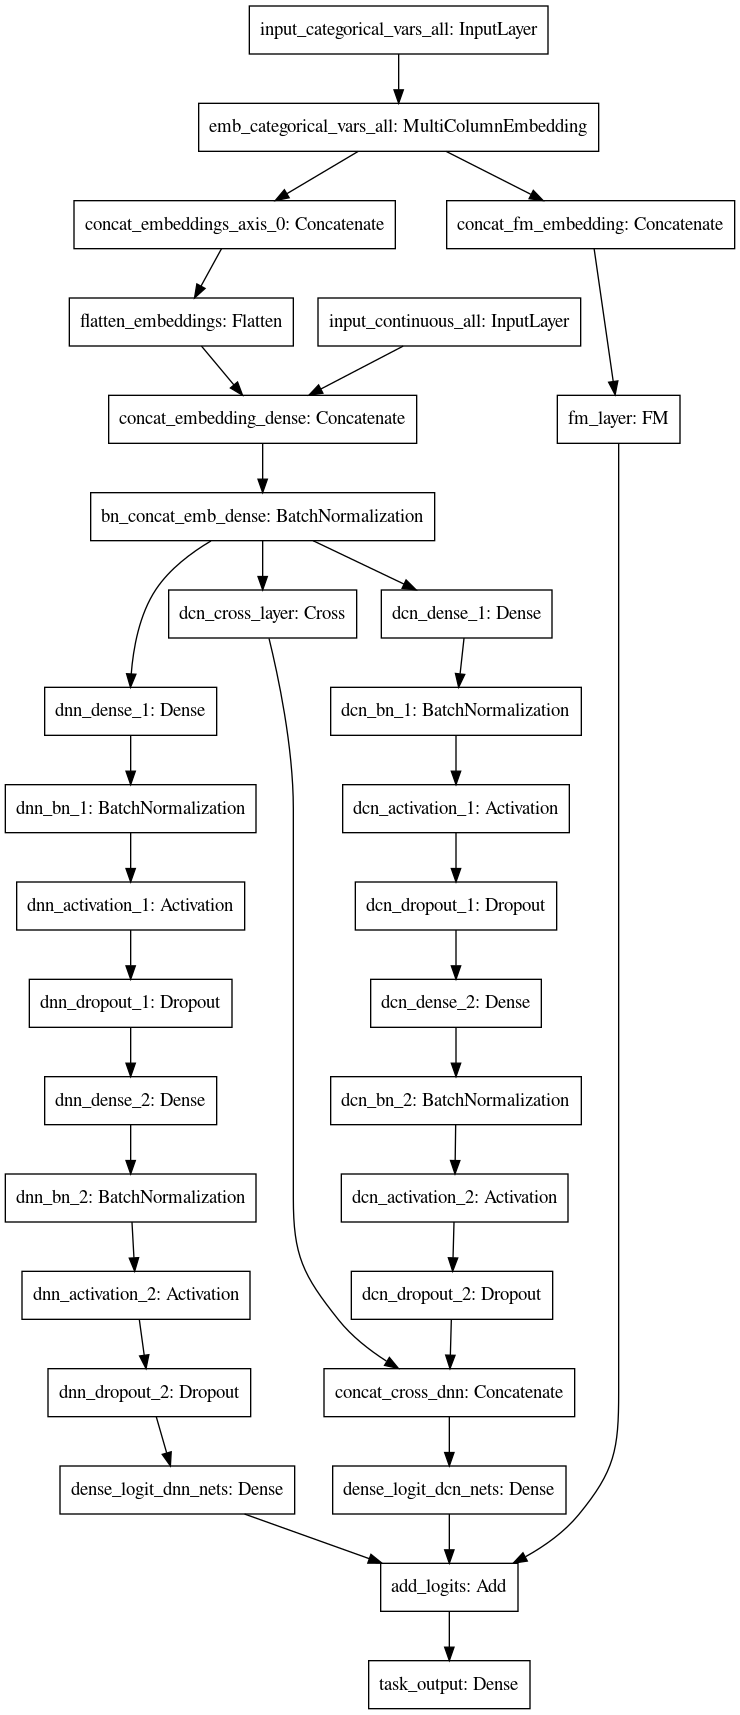

In [14]:
plot_model(dt.get_model().model,rankdir='TB')

In [15]:
%%time

conf = ModelConfig(
    dnn_params={
        'hidden_units':((300, 0.3, True),(300, 0.3, True),), 
        'dnn_activation':'relu',
    },
    fixed_embedding_dim=True, 
    embeddings_output_dim=20, 
     auto_discrete=False,
     auto_categorization=False,
    nets =['fm_nets','opnn_nets','cross_nets'],
    output_use_bias = False,
    pnn_params={
        'outer_product_kernel_type': 'mat',
    },    
    cross_params={
        'num_cross_layer': 4,
    },
)

dt = DeepTable(config = conf)
oof_proba, eval_proba, test_prob  = dt.fit_cross_validation(
    X, y, X_eval=None, X_test=None, 
    num_folds=n_folds, stratified=False, iterators=None,
    batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[], n_jobs=1)

Start cross validation
2 class detected, {0, 1}, so inferred as a [binary classification] task
Preparing features cost:0.02204585075378418
Imputation cost:0.04611682891845703
Categorical encoding cost:0.05957388877868652
fit_transform cost:0.13257122039794922
Iterators:KFold(n_splits=3, random_state=9527, shuffle=True)
Injected a callback [EarlyStopping]. monitor:val_AUC, patience:1, mode:max

Fold:1

1 Physical GPUs, 1 Logical GPUs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (23)', 'input_continuous_all: (5)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [4, 4, 4, 4, 4, 5, 8, 8, 8, 6, 592, 669, 206, 194, 748, 5, 7, 8, 17, 28, 174, 9, 14]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 465)
---------------------------------------------------------
nets: ['opnn_nets', 'fm_nets', 'cross_nets']
---------------------------------------------------------
opnn-outer_product: input_shape list(23), output_sha

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.7s finished


### Output submission

In [16]:
submission['target'] = test_prob
submission.to_csv(f'submission_fm_opnn_cross_kfold50.csv',index=False)

### Plot model

Load model from disk:dt_output/dt_20200324 160746_opnn_nets_fm_nets_cross_nets/opnn_nets_fm_nets_cross_nets-kfold-3.h5.
1 Physical GPUs, 1 Logical GPUs


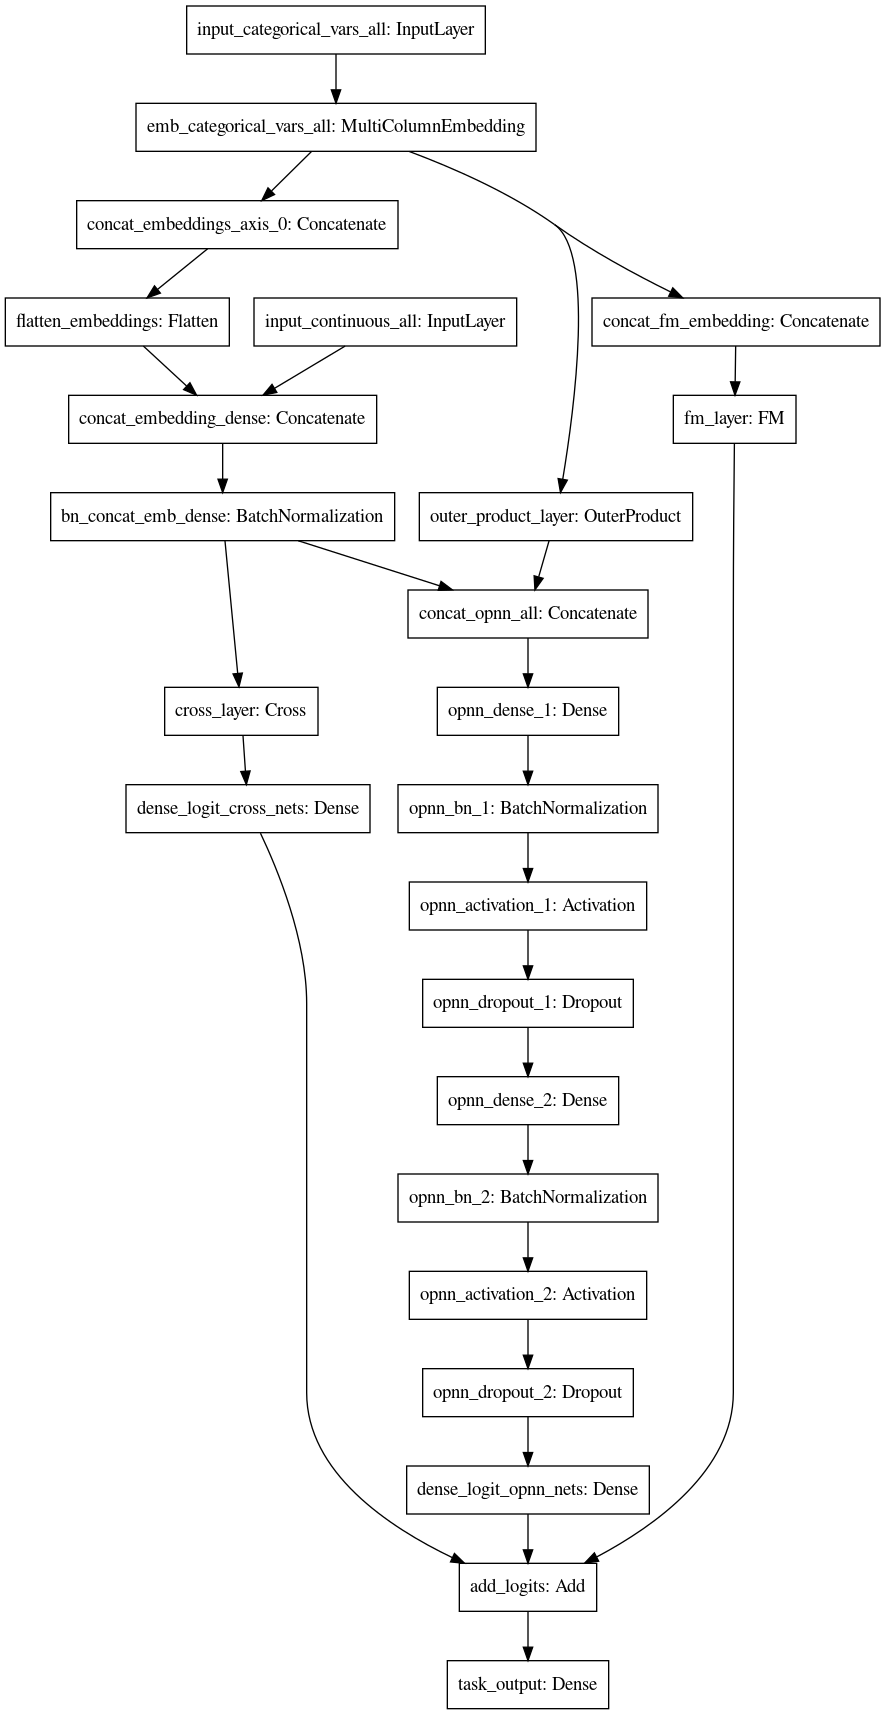

In [17]:
plot_model(dt.get_model().model,rankdir='TB')